# Threshold Experiment

Invalid input.
{500: {'df_data': [250, 250, 176.77669529663686, 176.77669529663686, 124.99999999999997, 124.99999999999997, 88.38834764831842, 88.38834764831842, 62.49999999999998, 62.49999999999998, 44.1941738241592, 44.1941738241592, 31.249999999999982, 31.249999999999982, 22.097086912079597, 22.097086912079597, 15.62499999999999, 15.62499999999999, 11.048543456039797, 11.048543456039797, 7.812499999999994, 7.812499999999994, 5.524271728019897, 5.524271728019897, 3.906249999999996, 3.906249999999996, 2.7621358640099483, 2.7621358640099483, 1.9531249999999978, 1.9531249999999978, 1.381067932004974, 1.381067932004974, 1.9531249999999978, 1.9531249999999978, 1.381067932004974, 1.381067932004974, 0.9765624999999987, 0.9765624999999987, 0.6905339660024868, 0.9765624999999987, 1.381067932004974], 'trial_data': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

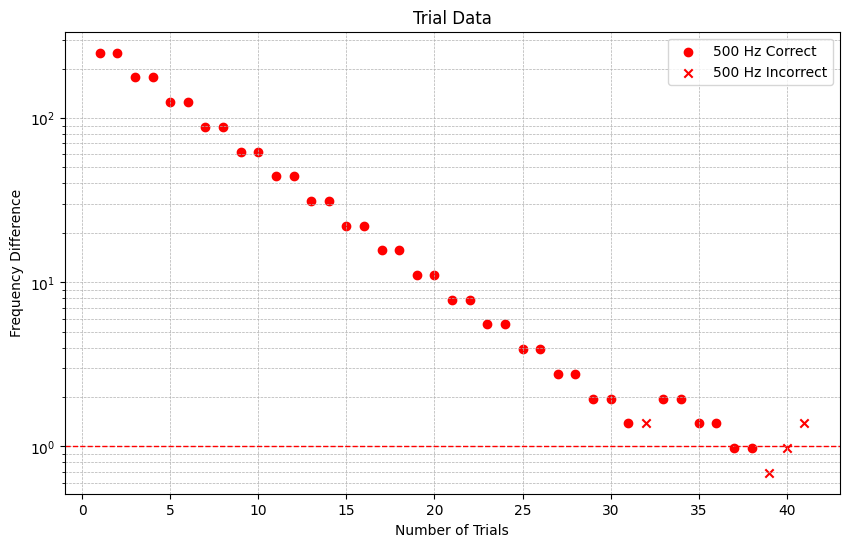

In [ ]:
import numpy as np
import sounddevice as sd
import time
import random
import matplotlib.pyplot as plt

# frequency: Hz
#      time: s
def play_sound(freq, s):
  sample_rate = 44100 # 44.1k standard
  nums = np.linspace(0, s, int(sample_rate * s), endpoint=False)
  sine = 0.5 * np.sin(2 * np.pi * freq * nums)
  sd.play(sine, sample_rate) # note: async
  time.sleep(s)

# map the user's response to a guess on whether the tones were swapped
response_map = {
  "1": True, # the first one is higher, so it was swapped
  "2": False # the second one is higher, so it was not swapped
}

# for performance due to reduced calculations
sqrt2 = 2 ** 0.5

# will test the user in tone comparisons relative to base_freq
def perform_test(base_freq, df=250):
  # data arrays
  trial_data = [] # True means correct
  df_data = []
  
  reversals = 0 # aka errors
  until_down = 2 # number of turns before going down
  
  while reversals < 4:
    tone_a = base_freq
    tone_b = base_freq + df
    
    # random chance to play swapped tones
    swap = random.randint(0, 1) == 1
    
    if swap:
      tone_a, tone_b = tone_b, tone_a
    
    play_sound(tone_a, 0.5)
    time.sleep(0.25)
    play_sound(tone_b, 0.5)
    
    # prompt input
    response = None
    while response == None:
      response = input("Which tone had a higher frequency? (1 / 2)\n>> ")
      if not response in response_map: # response not "1" or "2"
        print("Invalid input.")
        response = None
      else:
        # map response
        response = response_map[response]
    
    # append data
    df_data.append(df)
    
    if response == swap: # correct answer
      trial_data.append(True)
      
      # 2 down 1 up
      until_down -= 1
      if until_down == 0:
        df /= sqrt2 # decrease difference frequency
        until_down = 2
      
    else: # incorrect answer
      trial_data.append(False)
      reversals += 1
      
      # 2 down 1 up
      df *= sqrt2 # increase difference frequency
      until_down = 2
      
      # clamp it into a valid range to prevent weird negative errors
      minimum_frequency = 50
      if df - base_freq > minimum_frequency: 
        df = minimum_frequency
  
  # return data in dict
  return {
    "df_data": df_data,
    "trial_data": trial_data
  }

def plotData(data):
    # Define colors and markers for each frequency and correctness
    colors = {500: 'red', 750: 'blue', 1250: 'black'}
    markers = {True: 'o', False: 'x'}

    plt.figure(figsize=(10, 6))

    # Plot each frequency
    for freq, freq_data in data.items():
        df_data = freq_data['df_data']
        trial_data = freq_data['trial_data']
        trials = range(1, len(df_data) + 1)
        
        # Calculate the mean of the last 5 df values for this frequency
        mean_last_5 = np.mean(df_data[-5:])
        
        # Plot the threshold line for this frequency
        plt.axhline(y=mean_last_5, color=colors[freq], linestyle='--', linewidth=1)

        # Separate correct and incorrect trials
        for correct in [True, False]:
            # Select only correct or incorrect trials
            y_data = [df for df, t in zip(df_data, trial_data) if t == correct]
            x_data = [i for i, t in zip(trials, trial_data) if t == correct]
            
            # Plot
            plt.scatter(
                x_data, y_data,
                color=colors[freq],
                marker=markers[correct],
                label=f"{freq} Hz {'Correct' if correct else 'Incorrect'}"
            )

    # Set labels and title
    plt.yscale('log')  # Use logarithmic scale for y-axis
    plt.xlabel('Number of Trials')
    plt.ylabel('Frequency Difference')
    plt.title('Trial Data')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    return plt

data = {
  500: perform_test(500),
  # 750: perform_test(750),
  # 1250: perform_test(1250)
}

print(data)

plotData(data).show()